In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

In [2]:
import scipy as sp
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

In [3]:
df = pd.read_csv("data/rsbuddy/buy_average.csv")
df = df.set_index('timestamp')
df2 = pd.read_csv("data/rsbuddy/sell_average.csv")
df2 = df2.set_index('timestamp')

In [44]:
dropped = df.drop_duplicates()
dropped2 = df2.drop_duplicates()
selected = dropped[['Chaos_rune', 'Nature_rune', 'Soul_rune', 'Blood_rune', 'Law_rune', 'Rune_axe']]
selected = selected.replace(to_replace=0, method='ffill')
selected2 = dropped2[['Chaos_rune', 'Nature_rune', 'Soul_rune', 'Blood_rune', 'Law_rune']]
# y = runes.reset_index()['Chaos_rune']

In [45]:
print(selected.shape)
print(selected2.shape)
selected.head()

(1086, 6)
(1086, 5)


,Chaos_rune,Nature_rune,Soul_rune,Blood_rune,Law_rune,Rune_axe
timestamp,,,,,,
1577227800,66,218,146,305,142,7196
1577229600,66,219,147,304,142,7123
1577231400,66,218,146,304,142,7237
1577233501,66,218,145,304,140,7250
1577235300,66,218,144,301,140,7316


In [46]:
# stacked = pd.melt(df.reset_index(), id_vars=['timestamp'], value_vars=['Chaos_rune', 'Nature_rune', 'Soul_rune', 'Blood_rune', 'Law_rune'], var_name='var_name', value_name='value')
# print(stacked.head())

In [47]:
# extracted_features = extract_features(stacked, column_id="var_name", column_sort="timestamp")
# impute(extracted_features)

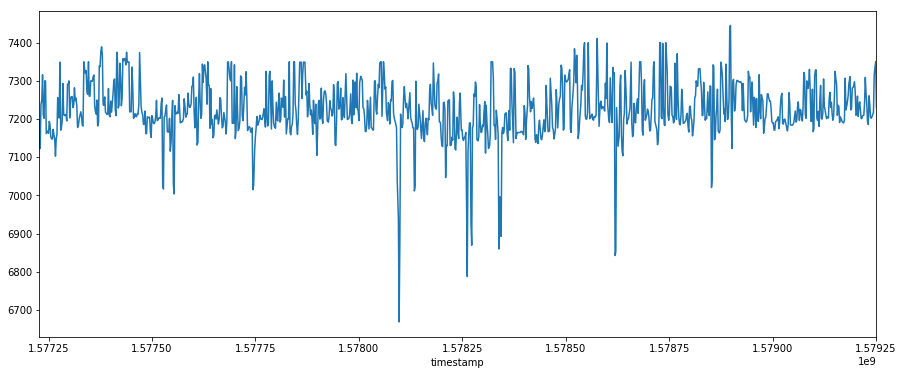

In [51]:
selected['Rune_axe'].plot(figsize=(15, 6))
plt.show()

In [54]:
df_shift, y = make_forecasting_frame(selected["Rune_axe"], kind="buy_average", max_timeshift=20, rolling_direction=1)

In [55]:
df_shift.head()

,time,value,id,kind
20425,1.577228e+09,7196.0,1577229600,buy_average
19341,1.577228e+09,7196.0,1577231400,buy_average
20426,1.577230e+09,7123.0,1577231400,buy_average
18258,1.577228e+09,7196.0,1577233501,buy_average
19342,1.577230e+09,7123.0,1577233501,buy_average


In [56]:
df_shift.shape

(21510, 4)

In [57]:
%%capture
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 10/10 [00:49<00:00,  4.10s/it]


In [58]:
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

(1085, 754)
(1085, 349)


In [59]:
# Add last value as feature
X["feature_last_value"] = y.shift(1)

In [60]:
# Drop first line
X = X.iloc[1:, ]
y = y.iloc[1: ]

In [61]:
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""",...,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,value__variance_larger_than_standard_deviation,feature_last_value
id,,,,,,,,,,,,,,,,,,,,,
1577231400,102519545.0,73.0,-1.000000,-1.000000,0.000000,7313.0,0.0,0.0,7285.5,-0.023931,...,1.0,1.0,1.0,1.0,0.000000e+00,0.000000e+00,0.0,1332.250000,1.0,7123.0
1577233501,154893714.0,187.0,-0.313019,-0.313019,0.314658,7313.0,0.0,0.0,7285.5,-0.023931,...,1.0,1.0,1.0,1.0,4.215057e+09,0.000000e+00,0.0,2222.888889,1.0,7237.0
1577235300,207456214.0,200.0,-0.337118,-0.108822,0.114951,7313.0,0.0,0.0,7285.5,-0.023931,...,1.0,1.0,1.0,1.0,8.712633e+09,0.000000e+00,0.0,2451.250000,1.0,7250.0
1577237100,260980070.0,266.0,-0.439896,-0.394378,0.312532,7313.0,0.0,0.0,7285.5,-0.023931,...,1.0,1.0,1.0,1.0,8.586832e+09,1.260280e+10,0.0,4058.640000,1.0,7316.0
1577238900,312978591.0,371.0,-0.215908,-0.151683,0.173034,7313.0,0.0,0.0,7316.0,-1.000000,...,1.0,1.0,1.0,1.0,5.408607e+09,1.087395e+10,0.0,3407.138889,1.0,7211.0


In [62]:

from tqdm import tqdm

In [63]:
ada = AdaBoostRegressor(n_estimators=10)
y_pred = [np.NaN] * len(y)

isp = 100   # index of where to start the predictions
assert isp > 0

for i in tqdm(range(isp, len(y))):
    
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    
y_pred = pd.Series(data=y_pred, index=y.index)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 984/984 [06:50<00:00,  1.22it/s]


In [64]:

# Dataframe of predictions and true values
ys = pd.concat([y_pred, y], axis = 1).rename(columns = {0: 'pred', 'value': 'true'})

# Convert index to a datetime
ys.index = pd.to_datetime(ys.index)
ys.head()

,pred,true
timestamp,,
1970-01-01 00:00:01.577231400,NaN,7237
1970-01-01 00:00:01.577233501,NaN,7250
1970-01-01 00:00:01.577235300,NaN,7316
1970-01-01 00:00:01.577237100,NaN,7211
1970-01-01 00:00:01.577238900,NaN,7202


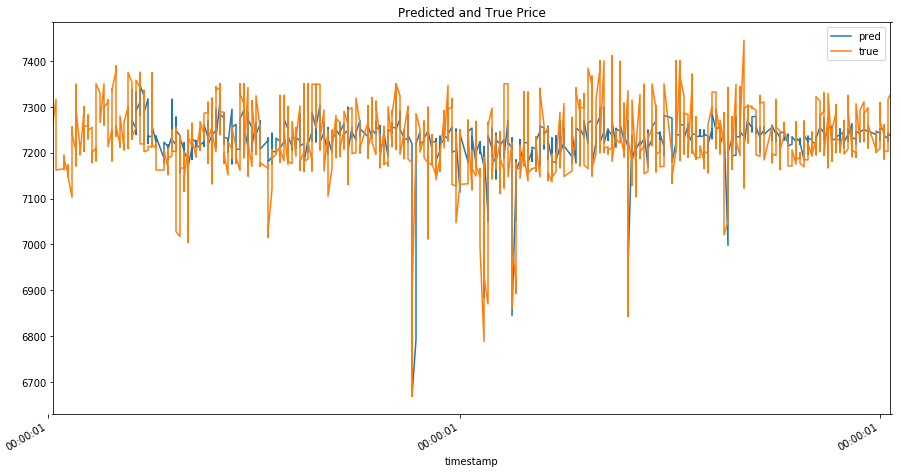

In [65]:
ys.plot(figsize=(15, 8))
plt.title('Predicted and True Price')
plt.show()

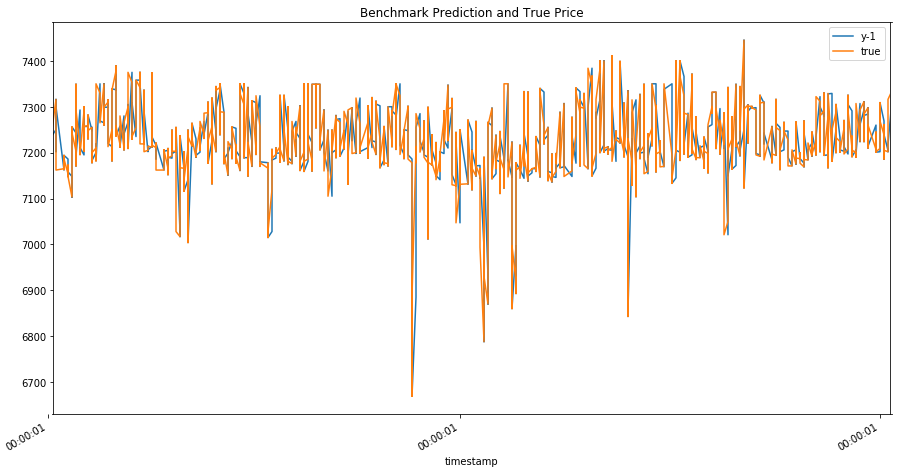

In [66]:
# Create column of previous price
ys['y-1'] = ys['true'].shift(1)
ys[['y-1', 'true']].plot(figsize = (15, 8))
plt.title('Benchmark Prediction and True Price')
plt.show()

In [67]:
print("MAE y-1: \t{}".format(np.mean(np.abs(np.diff(y))[isp-1:] )))
print("MAE ada: \t{}".format(np.mean(np.abs(y_pred - y)[isp:])))

MAE y-1: 	45.2469512195122
MAE ada: 	49.218769349604656


In [68]:
importances = pd.Series(index=X.columns, data=ada.feature_importances_)
importances.sort_values(ascending=False).head(10)

variable
feature_last_value                                                  0.309720
value__fft_coefficient__coeff_10__attr_"real"                       0.069801
value__skewness                                                     0.059883
value__fft_coefficient__coeff_7__attr_"angle"                       0.056987
value__fft_coefficient__coeff_8__attr_"real"                        0.044947
value__fft_coefficient__coeff_6__attr_"imag"                        0.037110
value__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"slope"    0.035908
value__agg_linear_trend__f_agg_"max"__chunk_len_5__attr_"stderr"    0.031676
value__mean_change                                                  0.027244
value__mean_second_derivative_central                               0.025086
dtype: float64